Here we refine the drug-target relations that we previously obtained from DrugBank.  The refinement concerns drug's activities on their targets and follows [the methods of Cheng et al 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6043492/#Sec7title), who filtered out low activity/affinity drug-target pairs by applying a 10 µM cutoff to $K_i, K_d, \mathrm{IC}_{50}$ or $\mathrm{EC}_{50}$.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
#from drugbank_downloader import download_drugbank, open_drugbank
import repos_tools
import proximity
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import attila_utils

GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


## Create drug-target network from ChEMBL

The following workflow creates a CSV formatted drug-target network from several tables of ChEMBL's SQLite database (see the [relational database schema](https://www.ebi.ac.uk/chembl/db_schema)).

1. for each phase 3 or 4 drug retreive all human protein targets
1. for each target retreive all $n$ activity assays and calculate $p\mathrm{Activity} = - \log_{10} \mathrm{Activity}$, where $\mathrm{Activity}$ is in $nM$ and may be $K_i, K_d, \mathrm{IC}_{50}, \mathrm{EC}_{50}, ...$
1. for each drug we remove low activity targets requiring that $n^{-1}\sum_{a=1}^n p\mathrm{Activity} \ge 5$

The last step corresponds to filtering with a $10 \mu M$ cutoff as Cheng et al 2018 performed.

For more details see the source code of `drug_target_avg_activity.sql`.

The last command executes the `SQL` selection script and writes the resulting table to `chembl-avg_p_activities-phase_3_4-avg_p_act_5plus.csv`.

## Adjust table for proximity calculation

1. extend table with Entrez gene IDs; see the [idmapping](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/) directory of UniProt KB
1. ensure it complies with the `src/proximity.py` script

In [2]:
fpath = '../../results/2021-10-24-chembl-query/chembl-avg_p_activities-phase_3_4-avg_p_act_5plus.csv'
dtn_chembl = pd.read_csv(fpath, index_col=('drug_chembl_id', 'target_uniprot_ac'))
dtn_chembl
#.set_index(['drug_chembl_id', 'target_uniprot_ac'])

drug_name  max_phase  \
drug_chembl_id target_uniprot_ac                               
CHEMBL1000     P35367                  CETIRIZINE          4   
CHEMBL1002     P07550              LEVOSALBUTAMOL          4   
               P10635              LEVOSALBUTAMOL          4   
               P16473              LEVOSALBUTAMOL          4   
               P19838              LEVOSALBUTAMOL          4   
...                                           ...        ...   
CHEMBL998      Q96RI1                  LORATADINE          4   
               Q9H2J7                  LORATADINE          4   
CHEMBL99946    P23975             LEVOMILNACIPRAN          4   
               P31645             LEVOMILNACIPRAN          4   
               Q01959             LEVOMILNACIPRAN          4   

                                                     indication_class  \
drug_chembl_id target_uniprot_ac                                        
CHEMBL1000     P35367                                  Antihistaminic   
CHEMBL1002     P07550             Bronchodilator; Asthma Prophylactic   
               P10635             Bronchodilator; Asthma Prophylactic   
               P16473             Bronchodilator; Asthma Prophylactic   
               P19838             Bronchodilator; Asthma Prophylactic   
...                                                               ...   
CHEMBL998      Q96RI1                                  Antihistaminic   
               Q9H2J7                                  Antihistaminic   
CHEMBL99946    P23975                                             NaN   
               P31645                                             NaN   
               Q01959                                             NaN   

                                                                        target_name  \
drug_chembl_id target_uniprot_ac                                                      
CHEMBL1000     P35367                                         Histamine H1 receptor   
CHEMBL1002     P07550                                    Beta-2 adrenergic receptor   
               P10635                                           Cytochrome P450 2D6   
               P16473                          Thyroid stimulating hormone receptor   
               P19838                        Nuclear factor NF-kappa-B p105 subunit   
...                                                                             ...   
CHEMBL998      Q96RI1                                        Bile acid receptor FXR   
               Q9H2J7             Sodium-dependent neutral amino acid transporte...   
CHEMBL99946    P23975                                    Norepinephrine transporter   
               P31645                                         Serotonin transporter   
               Q01959                                          Dopamine transporter   

                                     target_type  \
drug_chembl_id target_uniprot_ac                   
CHEMBL1000     P35367             SINGLE PROTEIN   
CHEMBL1002     P07550             SINGLE PROTEIN   
               P10635             SINGLE PROTEIN   
               P16473             SINGLE PROTEIN   
               P19838             SINGLE PROTEIN   
...                                          ...   
CHEMBL998      Q96RI1             SINGLE PROTEIN   
               Q9H2J7             SINGLE PROTEIN   
CHEMBL99946    P23975             SINGLE PROTEIN   
               P31645             SINGLE PROTEIN   
               Q01959             SINGLE PROTEIN   

                                                                 target_description  \
drug_chembl_id target_uniprot_ac                                                      
CHEMBL1000     P35367                                         Histamine H1 receptor   
CHEMBL1002     P07550                                    Beta-2 adrenergic receptor   
               P10635                                           Cytochrome P450 2D6   
             

In [3]:
fpath = '../../resources/UniProt/idmapping/HUMAN_9606_idmapping_selected.tab'
uniprot2entrez = pd.read_csv(fpath, sep='\t', usecols=[0, 2], dtype='str', names=['uniprot_ac', 'entrez_id'], index_col=0).squeeze()
uniprot2entrez = uniprot2entrez.apply(lambda x: set() if pd.isna(x) else set(x.split(';')))

All targets in the ChEMBL based drug-target network have a `target_uniprot_ac` that maps to an Entrez ID in `uniprot2entrez`.

In [4]:
A = set(dtn_chembl.index.get_level_values(1))
B = set(uniprot2entrez.index)
subsets = {k: len(v) for k, v in {'10': A.difference(B), '01': B.difference(A), '11': A.intersection(B)}.items()}
subsets

{'10': 0, '01': 200571, '11': 1589}

['named-figure/uniprot-entrez-venn.png',
 'named-figure/uniprot-entrez-venn.pdf']

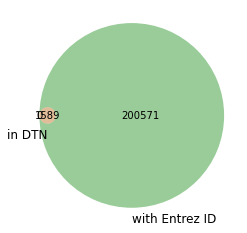

In [5]:
fig, ax = plt.subplots()
venn2(subsets=subsets, set_labels=('in DTN', 'with Entrez ID'))
attila_utils.savefig(fig, 'uniprot-entrez-venn')

`src/proximity.py` has been extended with new features reflecting the ChEMBL based drug-target network while preserving functionality for the DrugBank based drug-target network (this has been confirmed with test runs, see [2021-09-25-parallel.ipynb](https://github.com/attilagk/CTNS-notebook/blob/main/2021-09-25-parallel/2021-09-25-parallel.ipynb)).  Below is a test run on a small part of that drug-target network.

## Testrun with `src/proximity.py`

Notice the following changes:

* `drugbank_prot_fpath` and `drugbank_all_drugs_fpath` are omitted
* the new variable `drug_target_network_fpath` points to the drug-target network (in this case to the ChEMBL based one)

In [6]:
%%bash
cd ../../results/2021-10-24-chembl-query/
cat chembl-knowledge-test.cfg

[DEFAULT]
dis_genes_fpath = ../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge
network_fpath = ../../resources/PPI/Cheng2019/network.sif
id_mapping_file = ../../resources/PPI/geneid_to_symbol.txt
drug_target_network_fpath = chembl-avg_p_activities-phase_3_4-avg_p_act_5plus.csv 
asynchronous = yes
max_workers = 6
test_run = yes
out_csv = chembl-knowledge-test.csv


The result of the test run:

In [7]:
pd.read_csv('../../results/2021-10-24-chembl-query/chembl-knowledge-test.csv', index_col=0)

,drug_name,max_phase,indication_class,uniprot_name,target_name,d,avg_d_H0,sdev_d_H0,z,p
CHEMBL1000,CETIRIZINE,4,Antihistaminic,HRH1,Histamine H1 receptor,1.0,2.0090,0.308089,-3.275025,0.000528
CHEMBL1002,LEVOSALBUTAMOL,4,Bronchodilator; Asthma Prophylactic,ADRB2|CP2D6|TSHR|NFKB1|HIF1A,Beta-2 adrenergic receptor|Cytochrome P450 2D6...,2.0,1.5402,0.190116,2.418528,0.992208
CHEMBL100259,URIDINE,3,NaN,S28A1|GEMI|CDD,Sodium/nucleoside cotransporter 1|Geminin|Cyti...,2.0,1.8720,0.249231,0.513580,0.696227


## ChEMBL vs DrugBank
### Drugs in the ChEMBL drug-target network with existing DrugBank ID

In [8]:
fpath = '../../resources/UniChem/chembl2drugbank.tsv'
# read chembl -> drugbank ID converter into a series
chembl2drugbank = pd.read_csv(fpath, sep='\t', index_col=0).squeeze()

The Venn diagram shows that 642 compounds in the ChEMBL based drug-target network (DTN) do not have DrugBank IDs while 1784 do.  There are 6104 compounds with both ChEMBL ID and DrugBank ID that are not contained in the ChEMBL based DTN.

['named-figure/chembl-drugbank-venn.png',
 'named-figure/chembl-drugbank-venn.pdf']

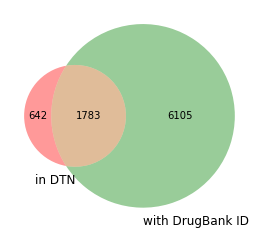

In [9]:
A = set(dtn_chembl.index.get_level_values(0))
B = set(chembl2drugbank.index)
fig, ax = plt.subplots()
subsets = {k: len(v) for k, v in {'10': A.difference(B), '01': B.difference(A), '11': A.intersection(B)}.items()}
venn2(subsets=subsets, set_labels=('in DTN', 'with DrugBank ID'))
attila_utils.savefig(fig, 'chembl-drugbank-venn')

Extending ChEMBL based drug-target network with DrugBank IDs

In [10]:
chembl2drugbank_dtn = chembl2drugbank.append(pd.Series(None, pd.Index(A.difference(B)), dtype='object'))
s = chembl2drugbank_dtn.loc[dtn_chembl.index.get_level_values(level=0)]
s.index = dtn_chembl.index
dtn_chembl['drugbank_id'] = s

### ChEMBL based and DrugBank based drug-target network

Below is the DrugBank based drug-target network

In [11]:
fpath = '../../results/2021-08-11-drugbank/drugbank-filtered-proteins.csv'
dtn_drugbank = pd.read_csv(fpath, index_col=(0, 1), dtype={'entrez_id': 'str'})
dtn_drugbank

symbol  \
drugbank_id uniprot_id          
DB00006     P00734         F2   
DB00007     P30968      GNRHR   
DB00014     P22888      LHCGR   
            P30968      GNRHR   
DB00035     P30518      AVPR2   
...                       ...   
DB15822     P21802      FGFR2   
DB15873     P30874      SSTR2   
DB15982     P03952      KLKB1   
DB16019     P07288       KLK3   
DB16353     P23467      PTPRB   

                                                                   name  \
drugbank_id uniprot_id                                                    
DB00006     P00734                                          Prothrombin   
DB00007     P30968              Gonadotropin-releasing hormone receptor   
DB00014     P22888         Lutropin-choriogonadotropic hormone receptor   
            P30968              Gonadotropin-releasing hormone receptor   
DB00035     P30518                              Vasopressin V2 receptor   
...                                                                 ...   
DB15822     P21802                  Fibroblast growth factor receptor 2   
DB15873     P30874                         Somatostatin receptor type 2   
DB15982     P03952                                    Plasma kallikrein   
DB16019     P07288                            Prostate-specific antigen   
DB16353     P23467      Receptor-type tyrosine-protein phosphatase beta   

                       category organism known_action    actions     hgnc_id  \
drugbank_id uniprot_id                                                         
DB00006     P00734       target   Humans          yes  inhibitor   HGNC:3535   
DB00007     P30968       target   Humans          yes    agonist   HGNC:4421   
DB00014     P22888       target   Humans          yes    agonist   HGNC:6585   
            P30968       target   Humans          yes    agonist   HGNC:4421   
DB00035     P30518       target   Humans          yes    agonist    HGNC:897   
...                         ...      ...          ...        ...         ...   
DB15822     P21802       target   Humans      unknown  inhibitor   HGNC:3689   
DB15873     P30874       target   Humans          yes     binder  HGNC:11331   
DB15982     P03952       target   Humans          yes  inhibitor   HGNC:6371   
DB16019     P07288       target   Humans          yes     binder   HGNC:6364   
DB16353     P23467       target   Humans          yes  inhibitor   HGNC:9665   

                                  group entrez_id  
drugbank_id uniprot_id                             
DB00006     P00734             approved      2147  
DB00007     P30968             approved      2798  
DB00014     P22888             approved      3973  
            P30968             approved      2798  
DB00035     P30518             approved       554  
...                                 ...       ...  
DB15822     P21802             approved      2263  
DB15873     P30874             approved      6752  
DB15982     P03952             approved      3818  
DB16019     P07288             approved       354  
DB16353     P23467      investigational      5787  

[12999 rows x 9 columns]

The operations below compute the Jaccard index or similarity coefficient between the targets listed in ChEMBL (after filtering at the $10 \mu M$ activity threshold) and those listed in DrugBank (where no filtering is possible since activities are not listed).

In [12]:
def collapse_dtn(dtn, name, extra_cols=['chembl_id', 'drug_name', 'max_phase', 'indication_class']):
    df = dtn.copy()
    df['uniprot_ac'] = df.index.get_level_values(1)
    gb = df.groupby('drugbank_id')
    a = gb.apply(lambda row: set(row.uniprot_ac)).to_frame(name)
    if extra_cols is None:
        return(a)
    else:
        b = gb[extra_cols].first()
        val = pd.concat([b, a], axis=1)
        return(val)

dtn_chembl['chembl_id'] = dtn_chembl.index.get_level_values(0)
collapsed_chembl = collapse_dtn(dtn_chembl.dropna(subset=['drugbank_id']), 'targets_chembl')
collapsed_drugbank = collapse_dtn(dtn_drugbank, 'targets_drugbank', None)
collapsed = pd.concat([collapsed_chembl, collapsed_drugbank], axis=1, join='inner')

def get_jaccard(A, B):
    jaccard = len(A.intersection(B)) / len(A.union(B))
    return(jaccard)

collapsed['jaccard_index'] = collapsed.apply(lambda row: get_jaccard(row.targets_chembl, row.targets_drugbank), axis=1)
collapsed['n_targets_chembl'] = collapsed['targets_chembl'].apply(len)
collapsed['n_targets_drugbank'] = collapsed['targets_drugbank'].apply(len)
collapsed.to_csv('../../results/2021-10-24-chembl-query/chembl-drugbank-targets-jaccardix.csv')

Some drugs of interest.  Alcohol is chosen since it has been noted to have very many targets listed in DrugBank.  The rest are Alzheimer's disease relevant drugs.

In [13]:
collapsed.loc[collapsed.drug_name.isin(['ALCOHOL', 'HYDROXYCHLOROQUINE', 'DEXMETHYLPHENIDATE', 'SILDENAFIL'])]

,chembl_id,drug_name,max_phase,indication_class,targets_chembl,targets_drugbank,jaccard_index,n_targets_chembl,n_targets_drugbank
drugbank_id,,,,,,,,,
DB00203,CHEMBL192,SILDENAFIL,4,Impotence Therapy,"{O15440, Q13956, P16499, Q08499, Q07343, Q9Y23...","{P18545, Q13956, O76074}",0.125000,24,3
DB00898,CHEMBL545,ALCOHOL,4,"Pharmaceutic Aid (solvent); Anti-Infective, To...","{P16473, P27695}","{P48051, Q8TCU5, Q01668, P17787, P28472, Q70Z4...",0.000000,2,52
DB01611,CHEMBL1535,HYDROXYCHLOROQUINE,4,Antimalarial; Suppressant (lupus erythematosus),"{Q5BJF2, Q99720, Q9NYK1, Q12809, P20309, P0817...","{Q9NYK1, Q9BYF1, Q9NR96}",0.181818,10,3
DB06701,CHEMBL827,DEXMETHYLPHENIDATE,4,None,{Q01959},"{P31645, P23975, Q01959}",0.333333,1,3


The plot shows that the Jaccard index is quite low for most of the drugs, especially when there are many targets listed in either data bases.

['named-figure/jaccard-targets-chembl-drugbank.png',
 'named-figure/jaccard-targets-chembl-drugbank.pdf']

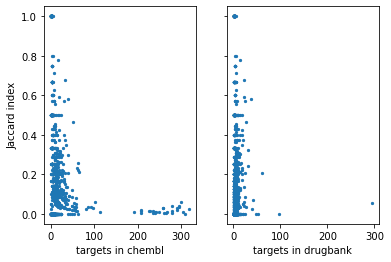

In [14]:
fig, ax = plt.subplots(1, 2, sharey=True)
def myplot(database, axes):
    collapsed.plot(kind='scatter', x='n_targets_' + database, y='jaccard_index', marker='.', ax=axes)
    axes.set_xlabel('targets in ' + database)
    #return(axes)

myplot('chembl', ax[0])
myplot('drugbank', ax[1])
ax[0].set_ylabel('Jaccard index')

attila_utils.savefig(fig, 'jaccard-targets-chembl-drugbank')

In [15]:
%connect_info

{
  "shell_port": 54189,
  "iopub_port": 54190,
  "stdin_port": 54191,
  "control_port": 54193,
  "hb_port": 54192,
  "ip": "127.0.0.1",
  "key": "69725741-b571c3a618d5f6db6775ccf9",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-c45dd138-12c4-496e-952a-34303ac54b4c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
